Needed libraries

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

import random
import cv2
import math

Function that recursively goes through directories levels and returns all folder names in a specific directory.

In [2]:
def getAllPerLevel(in_path, in_cLevel, in_fLevel):
    dirs = os.listdir(in_path)
    if(in_cLevel<in_fLevel):
        data = []
        for item in dirs:
            data.extend(getAllPerLevel(os.path.join(in_path,item), in_cLevel+1, in_fLevel))
        data = [item.lower() for item in data]
        dirs = np.unique(data)
        return dirs
    else:
        dirs = np.unique(dirs)
        return [item.lower() for item in dirs]

Function that returns folder size and number of files

In [3]:
def getDirStats(in_path):
    totalSize = 0
    numFiles = 0
    dirs = os.listdir(in_path)
    for dir in dirs:
        path = os.path.join(in_path, dir)
        if os.path.isfile(path):
            totalSize += os.path.getsize(path)
            numFiles += 1
    return totalSize, numFiles

Base dataset path

In [4]:
inPath = 'dataset'

Per class dictionary with the following values/keys:

classObjectData[objClass] = {'obj_class': The objClass itself,  
                             'num_back': Number of backgrounds,  
                             'num_light': Number of lightning conditions,  
                             'num_rep': Number of repetitions,  
                             'num_files': Number of files for the specific obj Class,  
                             'num_obj': Number of objects,  
                             'class_size': objClass size in bytes,  
                             'list_comb_ligh': strings that relates lightning with places,
                             'comb_light_place': nested  dictionaries with background information
                             }


In [18]:
dirFormat = os.path.join(inPath, '{obj_class}\\{lighting}\\{place}\\{background}')
numRep = 3


classes = getAllPerLevel(inPath, 0, 0)
lightingTypes = getAllPerLevel(inPath, 0, 1)
places = getAllPerLevel(inPath, 0, 2)

combsLight = []
for lightingType in lightingTypes:
    for place in places:
        combsLight.append('{0} x {1}'.format(lightingType, place))

classObjectData = {}
for objClass in classes:
    dictComb = {}
    for lighting in lightingTypes:
        for place in places:
            backgrounds = getAllPerLevel(os.path.join(inPath, objClass, lighting, place), 0, 0)
            dictBackgrounds = {}
            for background in backgrounds:
                aux = {'obj_class': objClass,
                       'lighting': lighting,
                       'place': place,
                       'background': background}
                pathAux = dirFormat.format(**aux)
                pathSize, numFiles = getDirStats(pathAux)
                dictBackgrounds[background] = {'path_size': pathSize,
                                               'num_files': numFiles,
                                               'dir': pathAux}
            dictComb[lighting, place] = dictBackgrounds
    numFiles = np.sum([np.sum([dictComb[key][nestedKey]['num_files'] for nestedKey in dictComb[key]]) for key in dictComb])
    classSize = np.sum([np.sum([dictComb[key][nestedKey]['path_size'] for nestedKey in dictComb[key]]) for key in dictComb])
    classObjectData[objClass] = {'obj_class': objClass,
                                 'num_back': len(backgrounds),
                                 'num_light': len(combsLight),
                                 'num_rep': numRep,
                                 'num_files': numFiles,
                                 'num_obj': int(numFiles/(numRep*len(lightingTypes)*len(places)*len(backgrounds))),
                                 'class_size': classSize,
                                 'list_comb_ligh': combsLight,
                                 'comb_light_place': dictComb
                                 }

Calculates total num of files and total size

In [6]:
numImages = np.sum([classObjectData[key]['num_files'] for key in classObjectData])
datasetSize = np.round(np.sum([float(classObjectData[key]['class_size']) for key in classObjectData])/1e6,2)

Tabela Global Sumaria

In [7]:
print('===================================')
print('Tabela Global Sumaria')
print('Numero de classes | {:d}'.format(len(classes)))
print('Numero de imagens | {:d}'.format(numImages))
print('Tamanho da base(bytes) | {:.2f} MB'.format(datasetSize))
print('===================================')

Tabela Global Sumaria
Numero de classes | 10
Numero de imagens | 1526
Tamanho da base(bytes) | 5044.69 MB


Tabela detalhada por classe

In [12]:
print('===================================')
print('Tabela detalhada por classe')
for key in classObjectData:
    print('{obj_class} | {num_obj} objetos | {num_back} variacoes de fundo por iluminacao  | '
          '{num_light} variacoes de iluminacao | {num_rep} repeticoes | {num_files} amostras'.format(**classObjectData[key]))
    dictLightPlace = classObjectData[key]['comb_light_place']    
    for key in dictLightPlace:
        dictBackgrounds = dictLightPlace[key]
        print('{0} x {1}'.format(key, tuple([item for item in dictBackgrounds.keys()])))
    print('\n')
print('===================================')

Tabela detalhada por classe
batom | 4 objetos | 3 variacoes de fundo por iluminacao  | 4 variacoes de iluminacao | 3 repeticoes | 144 amostras
('dia', 'dentro') x ('branco', 'gelo listras', 'marrom')
('dia', 'fora') x ('branco', 'gelo listras', 'marrom')
('noite', 'dentro') x ('branco', 'gelo listras', 'marrom')
('noite', 'fora') x ('branco', 'gelo listras', 'marrom')


caixa de cha | 3 objetos | 3 variacoes de fundo por iluminacao  | 4 variacoes de iluminacao | 3 repeticoes | 108 amostras
('dia', 'dentro') x ('fundo 1', 'fundo 2', 'fundo 3')
('dia', 'fora') x ('fundo 1', 'fundo 2', 'fundo 3')
('noite', 'dentro') x ('fundo 1', 'fundo 2', 'fundo 3')
('noite', 'fora') x ('fundo 1', 'fundo 2', 'fundo 3')


caneca | 3 objetos | 3 variacoes de fundo por iluminacao  | 4 variacoes de iluminacao | 3 repeticoes | 108 amostras
('dia', 'dentro') x ('fundo 1', 'fundo 2', 'fundo 3')
('dia', 'fora') x ('fundo 1', 'fundo 2', 'fundo 3')
('noite', 'dentro') x ('fundo 1', 'fundo 2', 'fundo 3')
('noite',

Visualizar a base usando funções MNIST-like

<ipython-input-20-cff9fbb514ab>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(numRows, numColumns, idx+1, xticks=[], yticks=[])


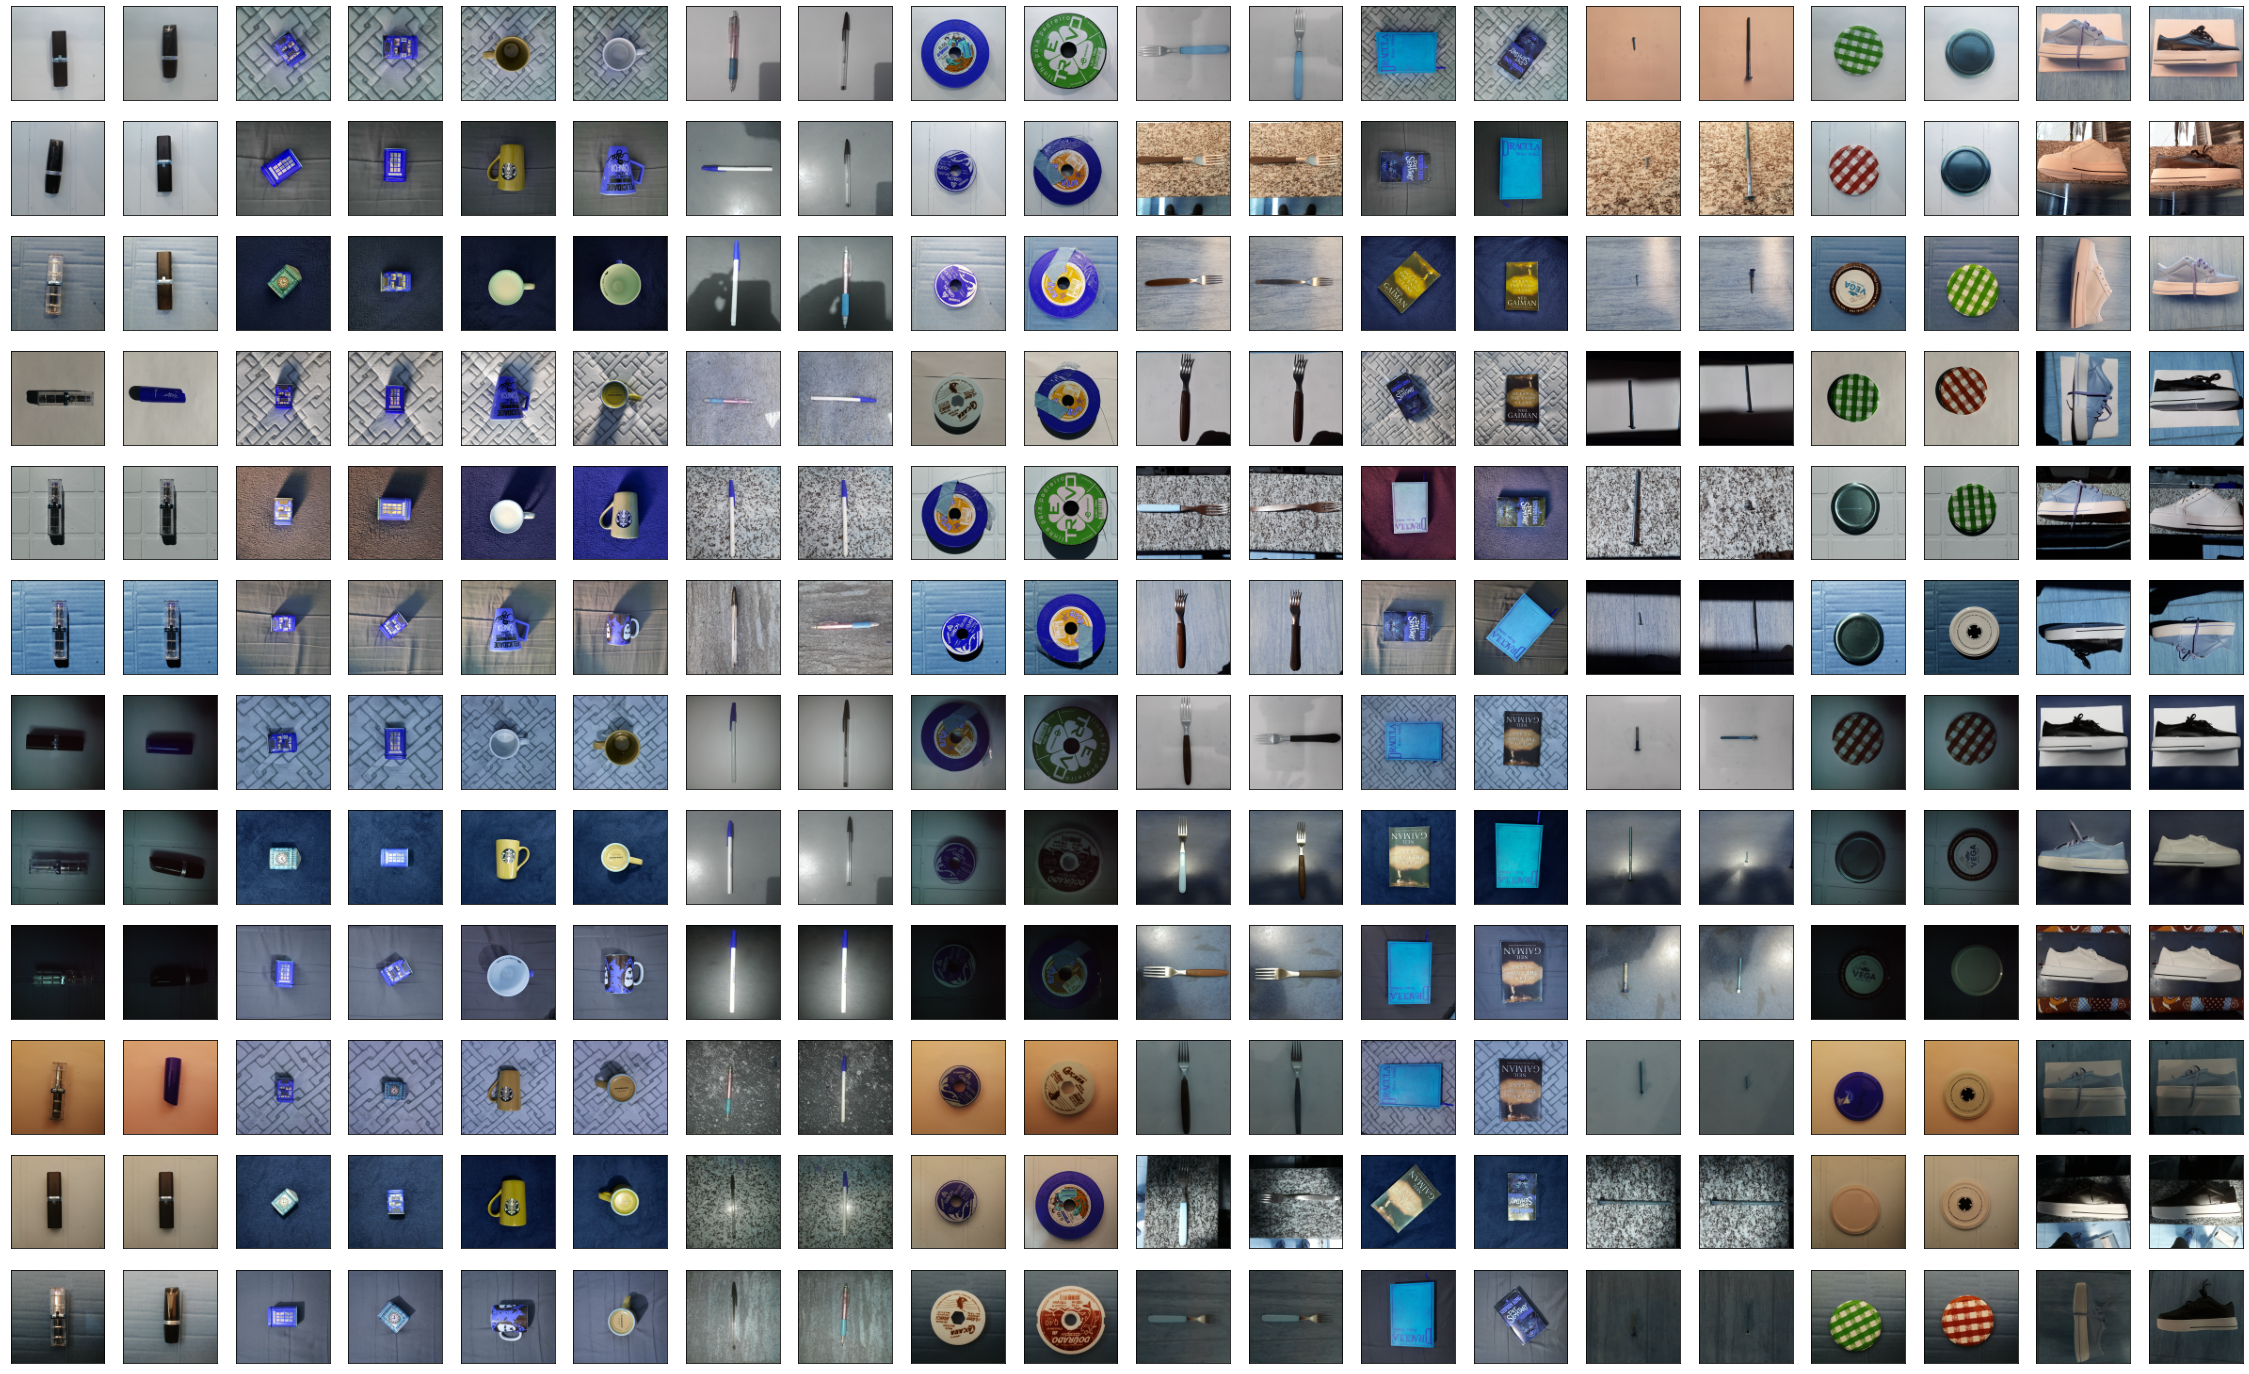

In [20]:
minNumObj = 2
minNumBack = int(np.min([classObjectData[key]['num_back'] for key in classObjectData]))
images = []
labels = []
for lighting in lightingTypes:
    for place in places:
        for posBackground in range(minNumBack):
            for key in classObjectData:
                dictLightPlace = classObjectData[key]['comb_light_place']
                dictBackground = dictLightPlace[lighting, place]
                backKeys = list(dictBackground.keys())
                path = dictBackground[backKeys[posBackground]]['dir']
                dirs = os.listdir(path)
                randomDirs = random.sample(dirs, minNumObj)
                for dir in randomDirs:
                    images.append(cv2.resize(cv2.imread(os.path.join(path, dir)), (100,100), interpolation = cv2.INTER_AREA))
                    labels.append(key)


numColumns = int(minNumObj*len(classObjectData.keys()))
numRows = len(labels)/numColumns

fig = plt.figure(figsize=(40, 25))

for idx in np.arange(len(labels)):
    ax = fig.add_subplot(numRows, numColumns, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])